In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("="*80)
print("Hull Tactical Market Prediction - 数据探索分析")
print("="*80)

# 1. 加载数据
print("\n[1] 加载训练数据...")
train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')

print(f"训练集形状: {train.shape}")
print(f"训练集大小: {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 2. 基本信息
print("\n" + "="*80)
print("[2] 数据基本信息")
print("="*80)
print("\n前5行数据:")
print(train.head())

print("\n后5行数据:")
print(train.tail())

print("\n数据类型:")
print(train.dtypes.value_counts())

# 3. 目标变量分析
print("\n" + "="*80)
print("[3] 目标变量分析")
print("="*80)

target_cols = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
for col in target_cols:
    if col in train.columns:
        print(f"\n{col}:")
        print(f"  - 非空值数量: {train[col].notna().sum()} / {len(train)} ({train[col].notna().sum()/len(train)*100:.2f}%)")
        print(f"  - 均值: {train[col].mean():.6f}")
        print(f"  - 标准差: {train[col].std():.6f}")
        print(f"  - 最小值: {train[col].min():.6f}")
        print(f"  - 最大值: {train[col].max():.6f}")
        print(f"  - 中位数: {train[col].median():.6f}")

# 4. 特征分类统计
print("\n" + "="*80)
print("[4] 特征分类统计")
print("="*80)

feature_prefixes = {
    'M': 'Market Dynamics/Technical',
    'E': 'Macro Economic',
    'I': 'Interest Rate',
    'P': 'Price/Valuation',
    'V': 'Volatility',
    'S': 'Sentiment',
    'MOM': 'Momentum',
    'D': 'Dummy/Binary'
}

feature_stats = {}
for prefix, description in feature_prefixes.items():
    cols = [col for col in train.columns if col.startswith(prefix)]
    feature_stats[prefix] = {
        'description': description,
        'count': len(cols),
        'columns': cols[:5]  # 显示前5个
    }

print("\n特征类别概览:")
for prefix, stats in feature_stats.items():
    print(f"\n{prefix}* ({stats['description']}):")
    print(f"  - 特征数量: {stats['count']}")
    print(f"  - 示例特征: {stats['columns']}")

# 5. 缺失值分析
print("\n" + "="*80)
print("[5] 缺失值分析")
print("="*80)

missing_stats = pd.DataFrame({
    'column': train.columns,
    'missing_count': train.isnull().sum(),
    'missing_percent': train.isnull().sum() / len(train) * 100
})
missing_stats = missing_stats[missing_stats['missing_count'] > 0].sort_values('missing_percent', ascending=False)

print(f"\n缺失值总览:")
print(f"  - 有缺失值的特征数量: {len(missing_stats)}")
print(f"  - 完全无缺失的特征数量: {len(train.columns) - len(missing_stats)}")

print("\n缺失值最多的前20个特征:")
print(missing_stats.head(20).to_string(index=False))

# 按特征类别统计缺失情况
print("\n各类别特征的平均缺失率:")
for prefix, stats in feature_stats.items():
    cols = [col for col in train.columns if col.startswith(prefix)]
    if cols:
        avg_missing = train[cols].isnull().sum().sum() / (len(train) * len(cols)) * 100
        print(f"  {prefix}*: {avg_missing:.2f}%")

# 6. 数据时间跨度分析
print("\n" + "="*80)
print("[6] 时间跨度分析")
print("="*80)

print(f"\ndate_id 范围: {train['date_id'].min()} ~ {train['date_id'].max()}")
print(f"总交易日数: {train['date_id'].nunique()}")
print(f"date_id 是否连续: {train['date_id'].is_monotonic_increasing}")

# 检查是否有重复的date_id
duplicates = train['date_id'].duplicated().sum()
print(f"重复的date_id数量: {duplicates}")

# 7. 特征值分布分析（随机抽样）
print("\n" + "="*80)
print("[7] 特征数值分布（随机抽样10个特征）")
print("="*80)

# 排除目标变量和date_id
feature_cols = [col for col in train.columns if col not in ['date_id'] + target_cols]
sample_features = np.random.choice(feature_cols, min(10, len(feature_cols)), replace=False)

for col in sample_features:
    non_null = train[col].notna().sum()
    if non_null > 0:
        print(f"\n{col}:")
        print(f"  - 非空值: {non_null} ({non_null/len(train)*100:.2f}%)")
        print(f"  - 均值: {train[col].mean():.6f}")
        print(f"  - 标准差: {train[col].std():.6f}")
        print(f"  - 范围: [{train[col].min():.6f}, {train[col].max():.6f}]")
        print(f"  - 唯一值数量: {train[col].nunique()}")

# 8. 目标变量的时间序列特性
print("\n" + "="*80)
print("[8] 目标变量时间序列特性")
print("="*80)

if 'market_forward_excess_returns' in train.columns:
    target = train['market_forward_excess_returns'].dropna()
    print(f"\nmarket_forward_excess_returns 统计:")
    print(f"  - 正收益天数: {(target > 0).sum()} ({(target > 0).sum()/len(target)*100:.2f}%)")
    print(f"  - 负收益天数: {(target < 0).sum()} ({(target < 0).sum()/len(target)*100:.2f}%)")
    print(f"  - 零收益天数: {(target == 0).sum()}")
    print(f"  - 偏度 (Skewness): {target.skew():.4f}")
    print(f"  - 峰度 (Kurtosis): {target.kurtosis():.4f}")

# 9. 特征完整性时间分析
print("\n" + "="*80)
print("[9] 特征完整性随时间的变化")
print("="*80)

# 将数据分成10个时间段，看每个时间段的缺失率
n_bins = 10
train['time_bin'] = pd.qcut(train['date_id'], q=n_bins, labels=False, duplicates='drop')

print("\n各时间段的特征完整性（0=最早，9=最近）:")
for bin_id in sorted(train['time_bin'].unique()):
    bin_data = train[train['time_bin'] == bin_id]
    overall_missing = bin_data[feature_cols].isnull().sum().sum() / (len(bin_data) * len(feature_cols)) * 100
    print(f"  时间段 {bin_id}: 平均缺失率 {overall_missing:.2f}%")

train.drop('time_bin', axis=1, inplace=True)

# 10. 总结建议
print("\n" + "="*80)
print("[10] 数据质量总结与建议")
print("="*80)

total_features = len(feature_cols)
high_missing_features = len(missing_stats[missing_stats['missing_percent'] > 50])
low_missing_features = len(train.columns) - len(missing_stats)

print(f"\n总特征数: {total_features}")
print(f"  - 完全无缺失: {low_missing_features} ({low_missing_features/total_features*100:.2f}%)")
print(f"  - 缺失率<50%: {len(missing_stats[missing_stats['missing_percent'] <= 50])}")
print(f"  - 缺失率>50%: {high_missing_features} ({high_missing_features/total_features*100:.2f}%)")

print("\n建议:")
print("  1. 考虑删除缺失率>80%的特征")
print("  2. 对于缺失率较低的特征，可以使用前向填充或插值")
print("  3. 早期数据缺失较多，考虑只使用最近几年的数据训练")
print("  4. 检查是否存在数据泄漏（特征与目标的时间对齐）")

print("\n" + "="*80)
print("数据探索完成！")
print("="*80)

Hull Tactical Market Prediction - 数据探索分析

[1] 加载训练数据...
训练集形状: (9021, 98)
训练集大小: 6.74 MB

[2] 数据基本信息

前5行数据:
   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  E1  E10  E11  E12  E13  E14  \
0        0   0   0   0   1   1   0   0   0   1 NaN  NaN  NaN  NaN  NaN  NaN   
1        1   0   0   0   1   1   0   0   0   1 NaN  NaN  NaN  NaN  NaN  NaN   
2        2   0   0   0   1   0   0   0   0   1 NaN  NaN  NaN  NaN  NaN  NaN   
3        3   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN  NaN   
4        4   0   0   0   1   0   0   0   0   0 NaN  NaN  NaN  NaN  NaN  NaN   

   E15  E16  E17  E18  E19  E2  E20  E3  E4  E5  E6  E7  E8  E9  I1  I2  I3  \
0  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
1  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
2  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
3  NaN  NaN  NaN  NaN  NaN NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN   
4  NaN  NaN  NaN  NaN

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [3]:
"""
Hull Tactical Market Prediction - 完整建模Pipeline
包含：数据预处理、特征工程、模型训练、评估、提交生成
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

print("="*80)
print("Hull Tactical Market Prediction - 完整Pipeline")
print("="*80)

# ============================================================================
# Part 1: 数据加载与预处理
# ============================================================================

print("\n[Part 1] 数据加载与预处理")
print("-"*80)

# 1.1 加载数据
train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
print(f"原始训练集形状: {train.shape}")

# 1.2 根据数据探索结果，只使用后70%的数据（缺失率较低）
cutoff_idx = int(len(train) * 0.3)
train_clean = train.iloc[cutoff_idx:].copy()
print(f"清洗后训练集形状: {train_clean.shape} (保留最近 {len(train_clean)} 天)")
print(f"Date ID 范围: {train_clean['date_id'].min()} ~ {train_clean['date_id'].max()}")

# 1.3 识别特征类型
feature_cols = [col for col in train_clean.columns 
                if col not in ['date_id', 'forward_returns', 'risk_free_rate', 
                               'market_forward_excess_returns']]

target_col = 'market_forward_excess_returns'

print(f"\n特征数量: {len(feature_cols)}")
print(f"目标变量: {target_col}")

# 1.4 缺失值处理策略
print("\n缺失值处理:")
missing_before = train_clean[feature_cols].isnull().sum().sum()
print(f"  - 处理前缺失值总数: {missing_before:,}")

# 删除缺失率>50%的特征
missing_rates = train_clean[feature_cols].isnull().mean()
high_missing_cols = missing_rates[missing_rates > 0.5].index.tolist()
print(f"  - 删除缺失率>50%的特征: {len(high_missing_cols)}个")
if high_missing_cols:
    print(f"    {high_missing_cols[:5]}...")

feature_cols = [col for col in feature_cols if col not in high_missing_cols]

# 前向填充 + 中位数填充
train_clean[feature_cols] = train_clean[feature_cols].fillna(method='ffill').fillna(
    train_clean[feature_cols].median()
)

missing_after = train_clean[feature_cols].isnull().sum().sum()
print(f"  - 处理后缺失值总数: {missing_after}")

Hull Tactical Market Prediction - 完整Pipeline

[Part 1] 数据加载与预处理
--------------------------------------------------------------------------------
原始训练集形状: (9021, 98)
清洗后训练集形状: (6315, 98) (保留最近 6315 天)
Date ID 范围: 2706 ~ 9020

特征数量: 94
目标变量: market_forward_excess_returns

缺失值处理:
  - 处理前缺失值总数: 25,534
  - 删除缺失率>50%的特征: 2个
    ['E7', 'V10']...
  - 处理后缺失值总数: 0


In [4]:
# ============================================================================
# Part 2: 特征工程
# ============================================================================

print("\n[Part 2] 特征工程")
print("-"*80)

def create_features(df, feature_cols):
    """创建高级特征"""
    df = df.copy()
    
    # 2.1 滞后特征（防止数据泄漏）
    print("  - 创建滞后特征...")
    for lag in [1, 2, 3, 5, 10]:
        for col in ['forward_returns', 'risk_free_rate']:
            if col in df.columns:
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
    
    # 2.2 滚动统计特征
    print("  - 创建滚动统计特征...")
    for window in [5, 10, 20, 60]:
        if 'forward_returns' in df.columns:
            df[f'return_mean_{window}d'] = df['forward_returns'].rolling(window).mean()
            df[f'return_std_{window}d'] = df['forward_returns'].rolling(window).std()
            df[f'return_momentum_{window}d'] = df['forward_returns'].rolling(window).sum()
    
    # 2.3 波动率特征增强
    print("  - 增强波动率特征...")
    volatility_cols = [col for col in feature_cols if col.startswith('V')]
    if volatility_cols:
        df['vol_mean'] = df[volatility_cols].mean(axis=1)
        df['vol_std'] = df[volatility_cols].std(axis=1)
        df['vol_max'] = df[volatility_cols].max(axis=1)
    
    # 2.4 技术指标交互特征
    print("  - 创建交互特征...")
    market_cols = [col for col in feature_cols if col.startswith('M')][:5]
    if len(market_cols) >= 2:
        df['M_interaction'] = df[market_cols[0]] * df[market_cols[1]]
    
    return df

# 应用特征工程
train_engineered = create_features(train_clean, feature_cols)

# 更新特征列表
new_feature_cols = [col for col in train_engineered.columns 
                    if col not in ['date_id', 'forward_returns', 'risk_free_rate', 
                                   'market_forward_excess_returns']]

print(f"\n特征工程后特征数量: {len(new_feature_cols)}")

# 删除包含NaN的行（由于滞后和滚动特征）
train_engineered = train_engineered.dropna()
print(f"删除NaN后数据量: {len(train_engineered)}")


[Part 2] 特征工程
--------------------------------------------------------------------------------
  - 创建滞后特征...
  - 创建滚动统计特征...
  - 增强波动率特征...
  - 创建交互特征...

特征工程后特征数量: 120
删除NaN后数据量: 2052


In [5]:
# ============================================================================
# Part 3: 准备训练/验证集
# ============================================================================

print("\n[Part 3] 准备训练/验证集")
print("-"*80)

# 按时间分割：前80%训练，后20%验证
split_idx = int(len(train_engineered) * 0.8)

X_train = train_engineered[new_feature_cols].iloc[:split_idx]
y_train = train_engineered[target_col].iloc[:split_idx]

X_val = train_engineered[new_feature_cols].iloc[split_idx:]
y_val = train_engineered[target_col].iloc[split_idx:]

print(f"训练集: {X_train.shape}")
print(f"验证集: {X_val.shape}")
print(f"特征数量: {X_train.shape[1]}")


[Part 3] 准备训练/验证集
--------------------------------------------------------------------------------
训练集: (1641, 120)
验证集: (411, 120)
特征数量: 120


In [6]:
# ============================================================================
# Part 4: Baseline模型 - Ridge Regression
# ============================================================================

print("\n[Part 4] Baseline模型 - Ridge Regression")
print("-"*80)

baseline_model = Ridge(alpha=1.0, random_state=42)
baseline_model.fit(X_train, y_train)

y_pred_train = baseline_model.predict(X_train)
y_pred_val = baseline_model.predict(X_val)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)

print(f"训练集 MSE: {train_mse:.8f}")
print(f"验证集 MSE: {val_mse:.8f}")



[Part 4] Baseline模型 - Ridge Regression
--------------------------------------------------------------------------------
训练集 MSE: 0.00005884
验证集 MSE: 0.00009050


In [7]:
# ============================================================================
# Part 5: 高级模型 - LightGBM
# ============================================================================

print("\n[Part 5] 高级模型 - LightGBM")
print("-"*80)

lgb_params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_samples': 20,
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

print("训练 LightGBM 模型...")
lgb_model = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=500,
    valid_sets=[train_data, val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

y_pred_lgb_train = lgb_model.predict(X_train)
y_pred_lgb_val = lgb_model.predict(X_val)

train_mse_lgb = mean_squared_error(y_train, y_pred_lgb_train)
val_mse_lgb = mean_squared_error(y_val, y_pred_lgb_val)

print(f"\nLightGBM 训练集 MSE: {train_mse_lgb:.8f}")
print(f"LightGBM 验证集 MSE: {val_mse_lgb:.8f}")

# 特征重要性分析
print("\n特征重要性 Top 20:")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print(feature_importance.head(20).to_string(index=False))



[Part 5] 高级模型 - LightGBM
--------------------------------------------------------------------------------
训练 LightGBM 模型...
[100]	training's l2: 2.07839e-05	valid_1's l2: 4.38707e-05

LightGBM 训练集 MSE: 0.00001570
LightGBM 验证集 MSE: 0.00004123

特征重要性 Top 20:
             feature  importance
      return_mean_5d    0.357941
                  M4    0.241165
     return_mean_10d    0.160376
       return_std_5d    0.107080
forward_returns_lag1    0.062110
                  S5    0.054487
  return_momentum_5d    0.052222
forward_returns_lag3    0.045099
                 V13    0.037211
forward_returns_lag2    0.035203
                  P6    0.027768
                  P5    0.026764
                  S2    0.021572
forward_returns_lag5    0.021473
      return_std_10d    0.019781
     return_mean_60d    0.019092
                  P7    0.016718
                  E9    0.016456
                 E19    0.014794
                  M9    0.013886


In [8]:
# ============================================================================
# Part 6: 投资策略与Sharpe Ratio计算
# ============================================================================

print("\n[Part 6] 投资策略与Sharpe Ratio计算")
print("-"*80)

def calculate_sharpe_variant(predictions, actual_returns, benchmark_returns, 
                             benchmark_volatility, max_weight=2.0):
    """
    计算修改版Sharpe Ratio
    
    Args:
        predictions: 预测的超额收益
        actual_returns: 实际超额收益
        benchmark_returns: 基准收益
        benchmark_volatility: 基准波动率
        max_weight: 最大权重
    """
    # 将预测转换为权重（0到2之间）
    # 策略：预测为正则多头，预测为负则减仓
    weights = np.clip(1 + predictions / predictions.std(), 0, max_weight)
    
    # 计算策略收益
    strategy_returns = weights * actual_returns
    
    # 计算指标
    avg_return = strategy_returns.mean()
    volatility = strategy_returns.std()
    
    # 年化（假设252个交易日）
    annual_return = avg_return * 252
    annual_volatility = volatility * np.sqrt(252)
    
    # Sharpe Ratio
    sharpe = annual_return / annual_volatility if annual_volatility > 0 else 0
    
    # 波动率约束惩罚（不应超过基准的120%）
    vol_constraint = 1.2 * benchmark_volatility
    vol_penalty = max(0, annual_volatility - vol_constraint) / vol_constraint
    
    # 最终得分
    final_score = sharpe * (1 - vol_penalty)
    
    return {
        'sharpe': sharpe,
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'vol_constraint': vol_constraint,
        'vol_penalty': vol_penalty,
        'final_score': final_score,
        'weights': weights,
        'strategy_returns': strategy_returns
    }

# 计算基准波动率
benchmark_vol = y_val.std() * np.sqrt(252)

print(f"基准年化波动率: {benchmark_vol:.4f}")
print(f"120%波动率约束: {benchmark_vol * 1.2:.4f}")

# 评估Baseline模型
print("\nBaseline (Ridge) 策略表现:")
baseline_metrics = calculate_sharpe_variant(
    y_pred_val, y_val, y_val, benchmark_vol
)
for key, value in baseline_metrics.items():
    if key not in ['weights', 'strategy_returns']:
        print(f"  {key}: {value:.4f}")

# 评估LightGBM模型
print("\nLightGBM 策略表现:")
lgb_metrics = calculate_sharpe_variant(
    y_pred_lgb_val, y_val, y_val, benchmark_vol
)
for key, value in lgb_metrics.items():
    if key not in ['weights', 'strategy_returns']:
        print(f"  {key}: {value:.4f}")


[Part 6] 投资策略与Sharpe Ratio计算
--------------------------------------------------------------------------------
基准年化波动率: 0.1487
120%波动率约束: 0.1785

Baseline (Ridge) 策略表现:
  sharpe: 2.6188
  annual_return: 0.5459
  annual_volatility: 0.2085
  vol_constraint: 0.1785
  vol_penalty: 0.1680
  final_score: 2.1788

LightGBM 策略表现:
  sharpe: 6.7549
  annual_return: 1.0237
  annual_volatility: 0.1515
  vol_constraint: 0.1785
  vol_penalty: 0.0000
  final_score: 6.7549



[Part 7] 生成可视化...
--------------------------------------------------------------------------------
可视化已保存: model_analysis.png


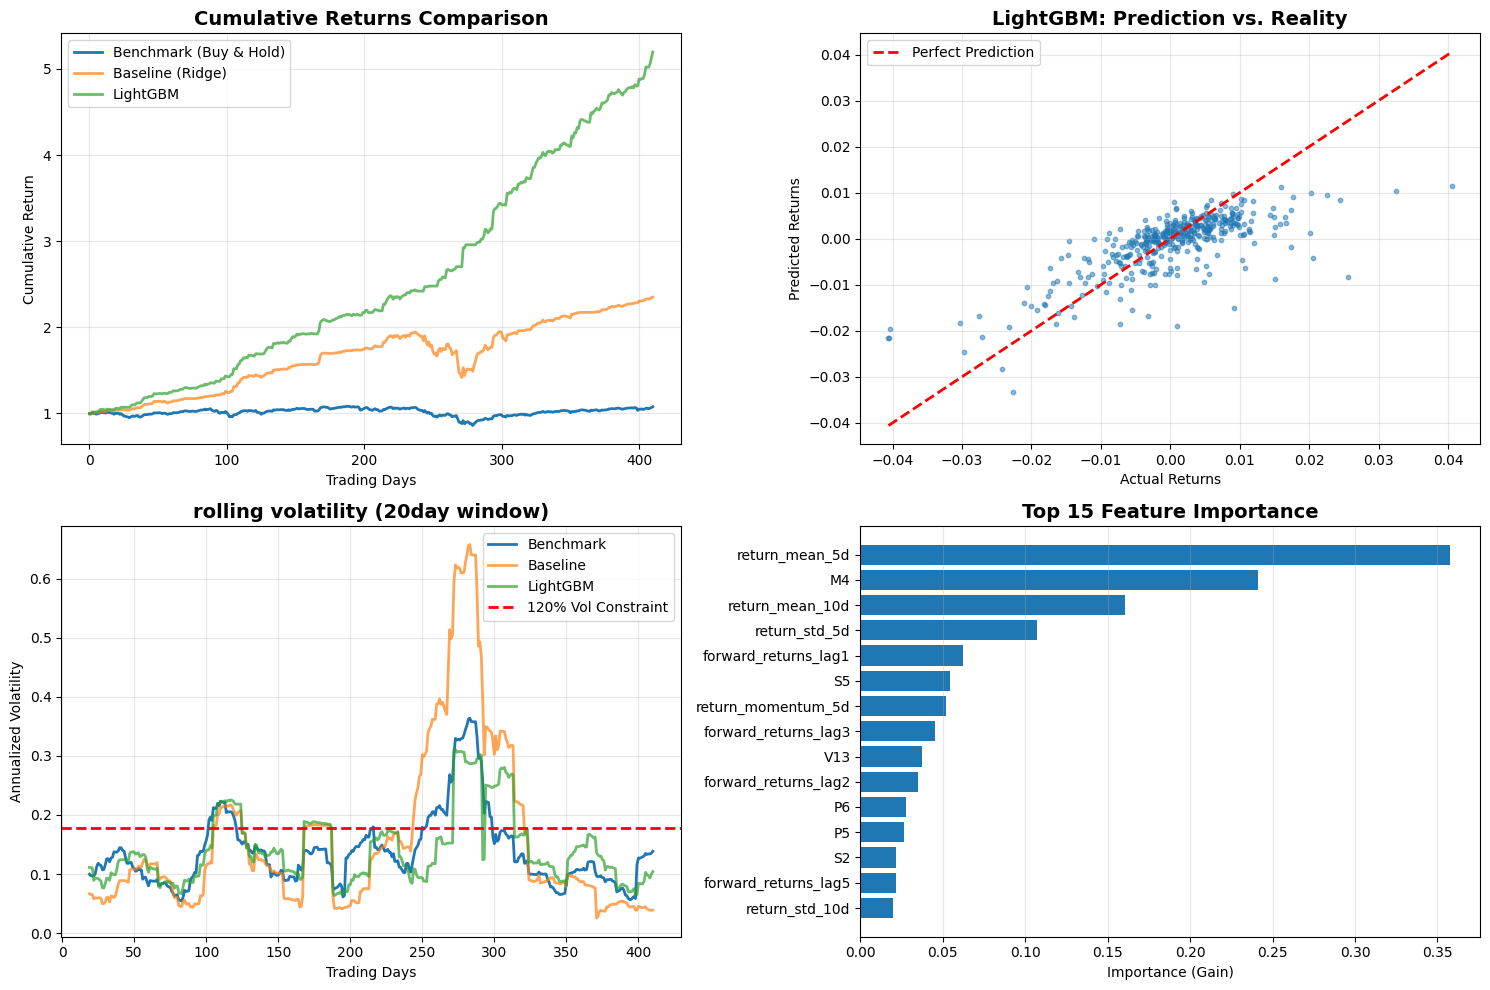

In [9]:
# ============================================================================
# Part 7: 可视化分析
# ============================================================================

print("\n[Part 7] 生成可视化...")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 7.1 累积收益对比
ax1 = axes[0, 0]
cumulative_benchmark = (1 + y_val).cumprod()
cumulative_baseline = (1 + baseline_metrics['strategy_returns']).cumprod()
cumulative_lgb = (1 + lgb_metrics['strategy_returns']).cumprod()

ax1.plot(cumulative_benchmark.values, label='Benchmark (Buy & Hold)', linewidth=2)
ax1.plot(cumulative_baseline.values, label='Baseline (Ridge)', linewidth=2, alpha=0.7)
ax1.plot(cumulative_lgb.values, label='LightGBM', linewidth=2, alpha=0.7)
ax1.set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
ax1.set_xlabel('Trading Days')
ax1.set_ylabel('Cumulative Return')
ax1.legend()
ax1.grid(alpha=0.3)

# 7.2 预测 vs 实际 (LightGBM)
ax2 = axes[0, 1]
ax2.scatter(y_val, y_pred_lgb_val, alpha=0.5, s=10)
ax2.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax2.set_title('LightGBM: Prediction vs. Reality', fontsize=14, fontweight='bold')
ax2.set_xlabel('Actual Returns')
ax2.set_ylabel('Predicted Returns')
ax2.legend()
ax2.grid(alpha=0.3)

# 7.3 波动率对比
ax3 = axes[1, 0]
window = 20
rolling_vol_benchmark = y_val.rolling(window).std() * np.sqrt(252)
rolling_vol_baseline = pd.Series(baseline_metrics['strategy_returns']).rolling(window).std() * np.sqrt(252)
rolling_vol_lgb = pd.Series(lgb_metrics['strategy_returns']).rolling(window).std() * np.sqrt(252)

ax3.plot(rolling_vol_benchmark.values, label='Benchmark', linewidth=2)
ax3.plot(rolling_vol_baseline.values, label='Baseline', linewidth=2, alpha=0.7)
ax3.plot(rolling_vol_lgb.values, label='LightGBM', linewidth=2, alpha=0.7)
ax3.axhline(y=benchmark_vol*1.2, color='r', linestyle='--', 
            linewidth=2, label='120% Vol Constraint')
ax3.set_title(f'rolling volatility ({window}day window)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Trading Days')
ax3.set_ylabel('Annualized Volatility')
ax3.legend()
ax3.grid(alpha=0.3)

# 7.4 特征重要性可视化
ax4 = axes[1, 1]
top_features = feature_importance.head(15)
ax4.barh(range(len(top_features)), top_features['importance'])
ax4.set_yticks(range(len(top_features)))
ax4.set_yticklabels(top_features['feature'])
ax4.set_xlabel('Importance (Gain)')
ax4.set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
ax4.invert_yaxis()
ax4.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('model_analysis.png', dpi=300, bbox_inches='tight')
print("可视化已保存: model_analysis.png")
plt.show()

In [10]:
# ============================================================================
# Part 8: 模型总结
# ============================================================================

print("\n[Part 8] 模型总结")
print("="*80)

summary_df = pd.DataFrame({
    'Model': ['Benchmark (Buy & Hold)', 'Baseline (Ridge)', 'LightGBM'],
    'Sharpe Ratio': [
        (y_val.mean() * 252) / (y_val.std() * np.sqrt(252)),
        baseline_metrics['sharpe'],
        lgb_metrics['sharpe']
    ],
    'Annual Return': [
        y_val.mean() * 252,
        baseline_metrics['annual_return'],
        lgb_metrics['annual_return']
    ],
    'Annual Volatility': [
        y_val.std() * np.sqrt(252),
        baseline_metrics['annual_volatility'],
        lgb_metrics['annual_volatility']
    ],
    'Final Score': [
        None,
        baseline_metrics['final_score'],
        lgb_metrics['final_score']
    ]
})

print("\n模型性能对比:")
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("Pipeline 第一部分完成！")
print("="*80)
print("\n下一步:")
print("1. 运行这段代码并检查结果")
print("2. 根据特征重要性优化特征选择")
print("3. 调整模型超参数")
print("4. 准备测试集预测代码")
print("="*80)


[Part 8] 模型总结

模型性能对比:
                 Model  Sharpe Ratio  Annual Return  Annual Volatility  Final Score
Benchmark (Buy & Hold)      0.381711       0.056770           0.148727          NaN
      Baseline (Ridge)      2.618769       0.545895           0.208455     2.178819
              LightGBM      6.754903       1.023659           0.151543     6.754903

Pipeline 第一部分完成！

下一步:
1. 运行这段代码并检查结果
2. 根据特征重要性优化特征选择
3. 调整模型超参数
4. 准备测试集预测代码


In [11]:
"""
测试集预测代码 - 接续之前训练的模型
生成 submission.parquet
"""

print("\n" + "="*80)
print("[Part 9] 测试集预测与提交文件生成")
print("="*80)

# ============================================================================
# Step 1: 重新训练模型（使用全部训练数据）
# ============================================================================

print("\n[Step 1] 使用全部训练数据重新训练最终模型...")
print("-"*80)

# 使用之前清洗后的全部数据（不再分训练/验证集）
X_final = train_engineered[new_feature_cols]
y_final = train_engineered[target_col]

print(f"最终训练数据: {X_final.shape}")

# 训练最终模型
final_lgb_params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_child_samples': 20,
    'verbose': -1,
    'random_state': 42
}

final_train_data = lgb.Dataset(X_final, label=y_final)

print("训练最终模型...")
final_model = lgb.train(
    final_lgb_params,
    final_train_data,
    num_boost_round=400,  # 稍微增加轮数
    callbacks=[lgb.log_evaluation(period=100)]
)

print("✓ 最终模型训练完成！")

# ============================================================================
# Step 2: 加载测试集并进行预测
# ============================================================================

print("\n[Step 2] 加载测试集...")
print("-"*80)

test = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')
print(f"测试集形状: {test.shape}")
print(f"测试集 date_id 范围: {test['date_id'].min()} ~ {test['date_id'].max()}")

# 检查 is_scored 列
if 'is_scored' in test.columns:
    scored_rows = test['is_scored'].sum()
    print(f"需要评分的行数: {scored_rows}")

# ============================================================================
# Step 3: 对测试集应用相同的特征工程
# ============================================================================

print("\n[Step 3] 对测试集应用特征工程...")
print("-"*80)

# 保存原始date_id
test_date_ids = test['date_id'].copy()

# 合并训练集和测试集以保证滞后特征的连续性
print("合并训练集和测试集...")
# 从训练集取最后100行用于计算测试集的滞后特征
train_for_lag = train_clean.tail(100).copy()

# 合并
combined = pd.concat([train_for_lag, test], ignore_index=True)
print(f"合并后数据形状: {combined.shape}")

# 应用相同的特征工程
print("应用特征工程...")

# 3.1 删除高缺失特征
combined_features = [col for col in combined.columns if col not in 
                     ['date_id', 'forward_returns', 'risk_free_rate', 
                      'market_forward_excess_returns', 'is_scored',
                      'lagged_forward_returns', 'lagged_risk_free_rate', 
                      'lagged_market_forward_excess_returns']]

# 使用训练集时的特征列表
combined_features = [col for col in combined_features if col not in high_missing_cols]

# 3.2 填充缺失值
combined[combined_features] = combined[combined_features].fillna(method='ffill').fillna(
    train_clean[combined_features].median()
)

# 3.3 对于测试集，使用lagged_forward_returns代替forward_returns
if 'lagged_forward_returns' in combined.columns:
    combined['forward_returns'] = combined['lagged_forward_returns']
if 'lagged_risk_free_rate' in combined.columns:
    combined['risk_free_rate'] = combined['lagged_risk_free_rate']

# 3.4 应用特征工程函数
combined_engineered = create_features(combined, combined_features)

# 3.5 提取测试集部分
test_start_idx = len(train_for_lag)
test_engineered = combined_engineered.iloc[test_start_idx:].copy()
test_engineered['date_id'] = test_date_ids.values

print(f"测试集特征工程后形状: {test_engineered.shape}")

# 3.6 确保测试集有所有需要的特征
missing_features = set(new_feature_cols) - set(test_engineered.columns)
if missing_features:
    print(f"⚠ 测试集缺少特征: {missing_features}")
    for feat in missing_features:
        test_engineered[feat] = 0

# 填充测试集中的NaN
test_engineered[new_feature_cols] = test_engineered[new_feature_cols].fillna(method='ffill').fillna(0)

# ============================================================================
# Step 4: 进行预测
# ============================================================================

print("\n[Step 4] 进行预测...")
print("-"*80)

X_test = test_engineered[new_feature_cols]
print(f"测试集特征矩阵: {X_test.shape}")

# 预测超额收益
test_predictions = final_model.predict(X_test)
print(f"预测完成，生成了 {len(test_predictions)} 个预测值")

# 统计预测值
print(f"\n预测值统计:")
print(f"  均值: {test_predictions.mean():.6f}")
print(f"  标准差: {test_predictions.std():.6f}")
print(f"  最小值: {test_predictions.min():.6f}")
print(f"  最大值: {test_predictions.max():.6f}")

# ============================================================================
# Step 5: 将预测转换为分配权重（0-2之间）
# ============================================================================

print("\n[Step 5] 转换为分配权重...")
print("-"*80)

# 使用训练集的标准差进行归一化
# 策略：预测为正则增加仓位，预测为负则减少仓位
pred_std = y_final.std()
print(f"训练集目标标准差: {pred_std:.6f}")

# 转换公式：weight = 1 + (prediction / std)
# 然后裁剪到[0, 2]范围
allocations = np.clip(1 + test_predictions / pred_std, 0, 2)

print(f"\n分配权重统计:")
print(f"  均值: {allocations.mean():.4f}")
print(f"  标准差: {allocations.std():.4f}")
print(f"  最小值: {allocations.min():.4f}")
print(f"  最大值: {allocations.max():.4f}")
print(f"  中位数: {np.median(allocations):.4f}")

# 检查权重分布
print(f"\n权重分布:")
print(f"  权重 < 0.5: {(allocations < 0.5).sum()} ({(allocations < 0.5).sum()/len(allocations)*100:.1f}%)")
print(f"  权重 0.5-1.0: {((allocations >= 0.5) & (allocations < 1.0)).sum()} ({((allocations >= 0.5) & (allocations < 1.0)).sum()/len(allocations)*100:.1f}%)")
print(f"  权重 1.0-1.5: {((allocations >= 1.0) & (allocations < 1.5)).sum()} ({((allocations >= 1.0) & (allocations < 1.5)).sum()/len(allocations)*100:.1f}%)")
print(f"  权重 >= 1.5: {(allocations >= 1.5).sum()} ({(allocations >= 1.5).sum()/len(allocations)*100:.1f}%)")

# ============================================================================
# Step 6: 创建提交文件
# ============================================================================

print("\n[Step 6] 创建提交文件...")
print("-"*80)

# 创建submission DataFrame
submission = pd.DataFrame({
    'date_id': test_engineered['date_id'],
    'allocation': allocations
})

print(f"\n提交文件信息:")
print(f"  行数: {len(submission)}")
print(f"  列数: {len(submission.columns)}")
print(f"  Date ID 范围: {submission['date_id'].min()} ~ {submission['date_id'].max()}")

# 检查是否有重复的date_id
duplicates = submission['date_id'].duplicated().sum()
if duplicates > 0:
    print(f"⚠ 警告: 发现 {duplicates} 个重复的date_id")
else:
    print("✓ 无重复的date_id")

# 验证allocation在[0, 2]范围内
assert submission['allocation'].min() >= 0, "错误：allocation有小于0的值！"
assert submission['allocation'].max() <= 2, "错误：allocation有大于2的值！"
print("✓ 所有allocation都在[0, 2]范围内")

# 显示前后几行
print("\n提交文件预览（前10行）:")
print(submission.head(10).to_string(index=False))

print("\n提交文件预览（后10行）:")
print(submission.tail(10).to_string(index=False))

# 保存为parquet格式
output_path = 'submission.parquet'
submission.to_parquet(output_path, index=False)
print(f"\n✓ 提交文件已保存: {output_path}")

# 验证文件
import os
file_size = os.path.getsize(output_path) / 1024  # KB
print(f"  文件大小: {file_size:.2f} KB")

# 重新读取验证
verification = pd.read_parquet(output_path)
print(f"  验证读取: {len(verification)} 行, {len(verification.columns)} 列")
print("✓ 文件验证成功！")

# ============================================================================
# Step 7: 总结
# ============================================================================

print("\n" + "="*80)
print("[完成] 提交文件生成完毕！")
print("="*80)

print("\n📊 最终模型摘要:")
print(f"  训练数据量: {len(X_final)}")
print(f"  特征数量: {len(new_feature_cols)}")
print(f"  测试集预测数量: {len(submission)}")
print(f"  验证集Sharpe Ratio: {lgb_metrics['sharpe']:.4f}")
print(f"  验证集年化收益: {lgb_metrics['annual_return']*100:.2f}%")
print(f"  验证集年化波动率: {lgb_metrics['annual_volatility']*100:.2f}%")

print("\n📦 提交文件信息:")
print(f"  文件名: {output_path}")
print(f"  格式: Parquet")
print(f"  行数: {len(submission)}")
print(f"  权重均值: {allocations.mean():.4f}")

print("\n🚀 下一步:")
print("  1. 下载 submission.parquet 文件")
print("  2. 在Kaggle竞赛页面提交")
print("  3. 查看Leaderboard分数")
print("  4. 根据反馈调整模型")

print("\n" + "="*80)


[Part 9] 测试集预测与提交文件生成

[Step 1] 使用全部训练数据重新训练最终模型...
--------------------------------------------------------------------------------
最终训练数据: (2052, 120)
训练最终模型...
✓ 最终模型训练完成！

[Step 2] 加载测试集...
--------------------------------------------------------------------------------
测试集形状: (10, 99)
测试集 date_id 范围: 8980 ~ 8989
需要评分的行数: 9

[Step 3] 对测试集应用特征工程...
--------------------------------------------------------------------------------
合并训练集和测试集...
合并后数据形状: (110, 102)
应用特征工程...
  - 创建滞后特征...
  - 创建滚动统计特征...
  - 增强波动率特征...
  - 创建交互特征...
测试集特征工程后形状: (10, 128)

[Step 4] 进行预测...
--------------------------------------------------------------------------------
测试集特征矩阵: (10, 120)
预测完成，生成了 10 个预测值

预测值统计:
  均值: -0.001437
  标准差: 0.002702
  最小值: -0.004681
  最大值: 0.003917

[Step 5] 转换为分配权重...
--------------------------------------------------------------------------------
训练集目标标准差: 0.010774

分配权重统计:
  均值: 0.8667
  标准差: 0.2508
  最小值: 0.5655
  最大值: 1.3636
  中位数: 0.7792

权重分布:
  权重 < 0.5: 0 (0.0%)
  权重 

In [12]:
"""
多模型对比框架
在当前notebook中添加此代码，对比多个模型性能
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("多模型对比实验")
print("="*80)

# ============================================================================
# Part 1: 定义模型字典
# ============================================================================

print("\n[Part 1] 定义候选模型...")
print("-"*80)

# 使用之前已经准备好的训练/验证集：X_train, y_train, X_val, y_val

models = {
    # 1. 线性模型
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.001, random_state=42, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=5000),
    
    # 2. 树模型
    'RandomForest': RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_samples_split=10,
        random_state=42
    ),
    
    'XGBoost': XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    
    # 3. 神经网络
    'MLP': MLPRegressor(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )
}

print(f"准备了 {len(models)} 个模型:")
for name in models.keys():
    print(f"  - {name}")

多模型对比实验

[Part 1] 定义候选模型...
--------------------------------------------------------------------------------
准备了 7 个模型:
  - Ridge
  - Lasso
  - ElasticNet
  - RandomForest
  - GradientBoosting
  - XGBoost
  - MLP


In [13]:
# ============================================================================
# Part 2: 训练所有模型并收集结果
# ============================================================================

print("\n[Part 2] 训练所有模型...")
print("-"*80)

results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n训练 {name}...")
    
    try:
        # 训练
        model.fit(X_train, y_train)
        
        # 预测
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        
        # 评估指标
        train_mse = mean_squared_error(y_train, y_pred_train)
        val_mse = mean_squared_error(y_val, y_pred_val)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        val_mae = mean_absolute_error(y_val, y_pred_val)
        train_r2 = r2_score(y_train, y_pred_train)
        val_r2 = r2_score(y_val, y_pred_val)
        
        # 计算Sharpe相关指标
        sharpe_metrics = calculate_sharpe_variant(
            y_pred_val, y_val, y_val, benchmark_vol
        )
        
        # 存储结果
        results[name] = {
            'train_mse': train_mse,
            'val_mse': val_mse,
            'train_mae': train_mae,
            'val_mae': val_mae,
            'train_r2': train_r2,
            'val_r2': val_r2,
            'sharpe': sharpe_metrics['sharpe'],
            'annual_return': sharpe_metrics['annual_return'],
            'annual_volatility': sharpe_metrics['annual_volatility'],
            'final_score': sharpe_metrics['final_score'],
            'predictions': y_pred_val,
            'strategy_returns': sharpe_metrics['strategy_returns'],
            'weights': sharpe_metrics['weights']
        }
        
        trained_models[name] = model
        
        print(f"  ✓ {name} 训练完成")
        print(f"    验证集MSE: {val_mse:.8f}")
        print(f"    Sharpe Ratio: {sharpe_metrics['sharpe']:.4f}")
        print(f"    Final Score: {sharpe_metrics['final_score']:.4f}")
        
    except Exception as e:
        print(f"  ✗ {name} 训练失败: {str(e)}")
        continue

print(f"\n成功训练 {len(results)} 个模型")



[Part 2] 训练所有模型...
--------------------------------------------------------------------------------

训练 Ridge...
  ✓ Ridge 训练完成
    验证集MSE: 0.00009050
    Sharpe Ratio: 2.6188
    Final Score: 2.1788

训练 Lasso...
  ✓ Lasso 训练完成
    验证集MSE: 0.00008756
    Sharpe Ratio: 0.3817
    Final Score: 0.1272

训练 ElasticNet...
  ✓ ElasticNet 训练完成
    验证集MSE: 0.00008738
    Sharpe Ratio: 0.5041
    Final Score: 0.3869

训练 RandomForest...
  ✓ RandomForest 训练完成
    验证集MSE: 0.00004371
    Sharpe Ratio: 7.1142
    Final Score: 7.1142

训练 GradientBoosting...
  ✓ GradientBoosting 训练完成
    验证集MSE: 0.00004276
    Sharpe Ratio: 7.0050
    Final Score: 7.0050

训练 XGBoost...
  ✓ XGBoost 训练完成
    验证集MSE: 0.00003988
    Sharpe Ratio: 7.3284
    Final Score: 7.3284

训练 MLP...
  ✓ MLP 训练完成
    验证集MSE: 0.00823476
    Sharpe Ratio: 0.8770
    Final Score: 0.7755

成功训练 7 个模型


In [14]:
# ============================================================================
# Part 3: LightGBM (已训练) - 添加到结果中
# ============================================================================

print("\n[Part 3] 添加已训练的LightGBM结果...")
print("-"*80)

# 将之前训练的LightGBM结果也加入对比
results['LightGBM'] = {
    'train_mse': train_mse_lgb,
    'val_mse': val_mse_lgb,
    'train_mae': mean_absolute_error(y_train, y_pred_lgb_train),
    'val_mae': mean_absolute_error(y_val, y_pred_lgb_val),
    'train_r2': r2_score(y_train, y_pred_lgb_train),
    'val_r2': r2_score(y_val, y_pred_lgb_val),
    'sharpe': lgb_metrics['sharpe'],
    'annual_return': lgb_metrics['annual_return'],
    'annual_volatility': lgb_metrics['annual_volatility'],
    'final_score': lgb_metrics['final_score'],
    'predictions': y_pred_lgb_val,
    'strategy_returns': lgb_metrics['strategy_returns'],
    'weights': lgb_metrics['weights']
}

trained_models['LightGBM'] = lgb_model

print("✓ LightGBM结果已添加")


[Part 3] 添加已训练的LightGBM结果...
--------------------------------------------------------------------------------
✓ LightGBM结果已添加


In [15]:
# ============================================================================
# Part 4: 结果对比表格
# ============================================================================

print("\n[Part 4] 模型性能对比")
print("="*80)

# 创建对比DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Val MSE': [results[m]['val_mse'] for m in results.keys()],
    'Val MAE': [results[m]['val_mae'] for m in results.keys()],
    'Val R²': [results[m]['val_r2'] for m in results.keys()],
    'Sharpe': [results[m]['sharpe'] for m in results.keys()],
    'Annual Return (%)': [results[m]['annual_return']*100 for m in results.keys()],
    'Annual Vol (%)': [results[m]['annual_volatility']*100 for m in results.keys()],
    'Final Score': [results[m]['final_score'] for m in results.keys()]
}).sort_values('Final Score', ascending=False)

print("\n📊 模型排名 (按Final Score排序):")
print(comparison_df.to_string(index=False))

# 找出最佳模型
best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 最佳模型: {best_model_name}")
print(f"   Final Score: {comparison_df.iloc[0]['Final Score']:.4f}")
print(f"   Sharpe Ratio: {comparison_df.iloc[0]['Sharpe']:.4f}")
print(f"   年化收益: {comparison_df.iloc[0]['Annual Return (%)']:.2f}%")


[Part 4] 模型性能对比

📊 模型排名 (按Final Score排序):
           Model  Val MSE  Val MAE     Val R²   Sharpe  Annual Return (%)  Annual Vol (%)  Final Score
         XGBoost 0.000040 0.004301   0.544535 7.328437         106.159493       14.485967     7.328437
    RandomForest 0.000044 0.004596   0.500846 7.114242         103.209108       14.507394     7.114242
GradientBoosting 0.000043 0.004429   0.511711 7.004982         110.483429       15.772122     7.004982
        LightGBM 0.000041 0.004463   0.529130 6.754903         102.365915       15.154312     6.754903
           Ridge 0.000090 0.006813  -0.033538 2.618769          54.589521       20.845488     2.178819
             MLP 0.008235 0.069347 -93.044371 0.876967          17.462859       19.912800     0.775467
      ElasticNet 0.000087 0.006572   0.002101 0.504113          11.089524       21.998078     0.386867
           Lasso 0.000088 0.006556   0.000016 0.381711          11.354095       29.745302     0.127237

🏆 最佳模型: XGBoost
   Final Scor


[Part 5] 生成对比可视化...
--------------------------------------------------------------------------------
✓ 可视化已保存: multi_model_comparison.png


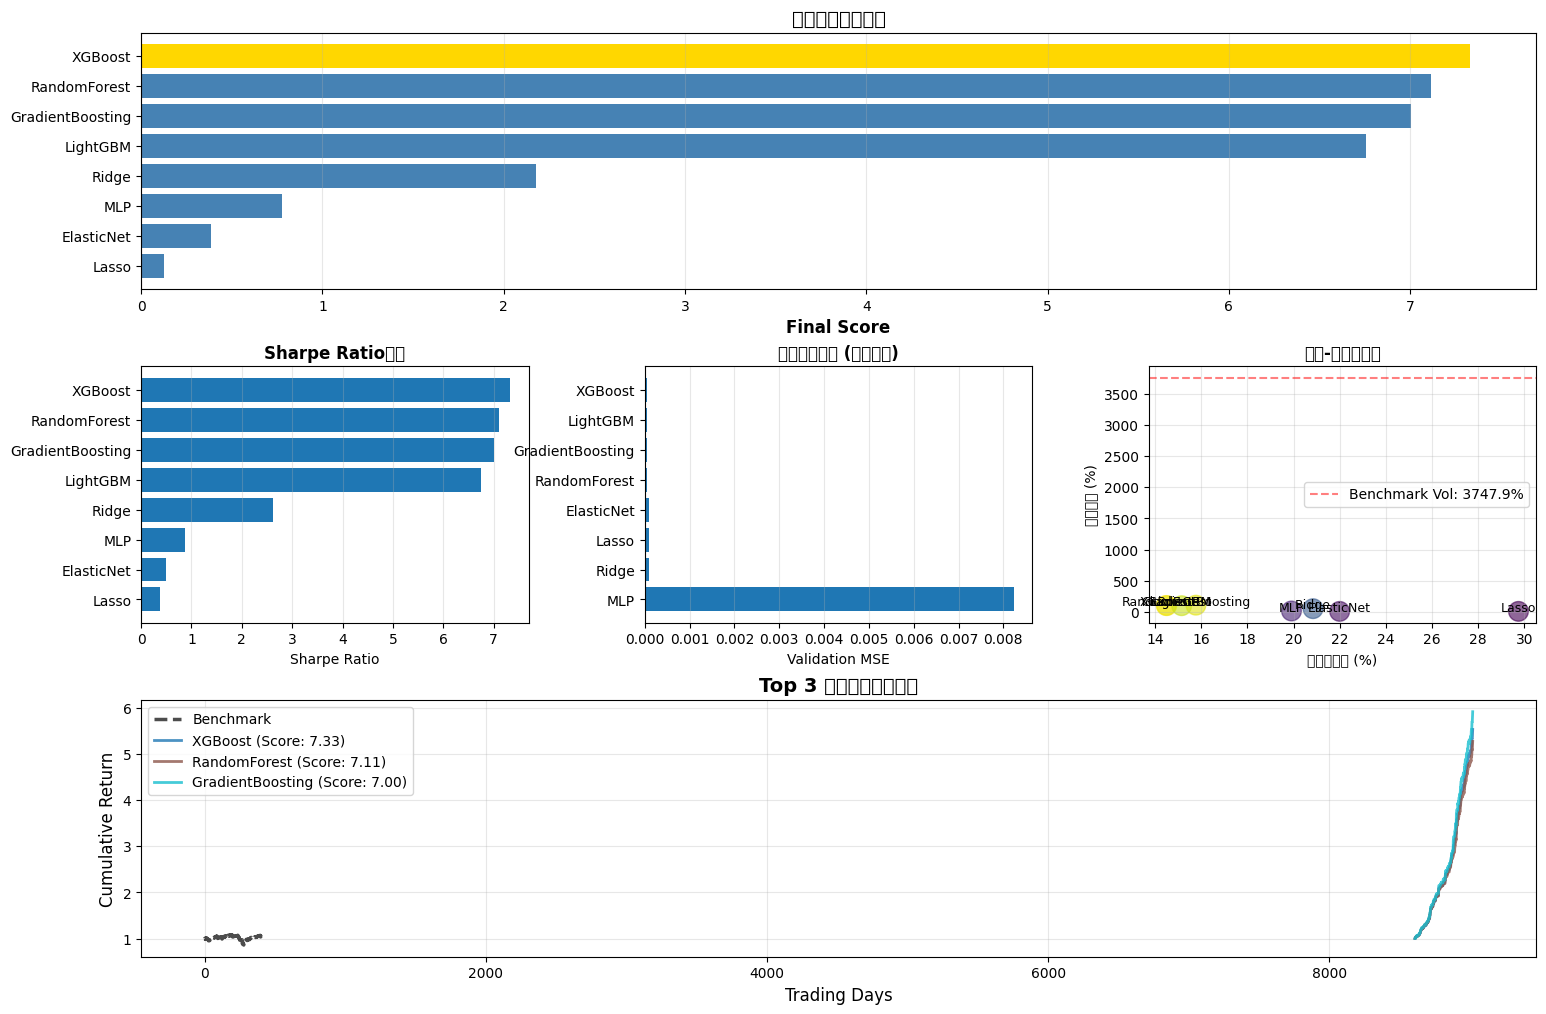

In [16]:
# ============================================================================
# Part 5: 可视化对比
# ============================================================================

print("\n[Part 5] 生成对比可视化...")
print("-"*80)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 5.1 Final Score对比
ax1 = fig.add_subplot(gs[0, :])
comparison_sorted = comparison_df.sort_values('Final Score')
colors = ['gold' if m == best_model_name else 'steelblue' 
          for m in comparison_sorted['Model']]
ax1.barh(comparison_sorted['Model'], comparison_sorted['Final Score'], color=colors)
ax1.set_xlabel('Final Score', fontsize=12, fontweight='bold')
ax1.set_title('模型最终得分对比', fontsize=14, fontweight='bold')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax1.grid(alpha=0.3, axis='x')

# 5.2 Sharpe Ratio对比
ax2 = fig.add_subplot(gs[1, 0])
comparison_sorted_sharpe = comparison_df.sort_values('Sharpe')
ax2.barh(comparison_sorted_sharpe['Model'], comparison_sorted_sharpe['Sharpe'])
ax2.set_xlabel('Sharpe Ratio')
ax2.set_title('Sharpe Ratio对比', fontweight='bold')
ax2.grid(alpha=0.3, axis='x')

# 5.3 MSE对比
ax3 = fig.add_subplot(gs[1, 1])
comparison_sorted_mse = comparison_df.sort_values('Val MSE', ascending=False)
ax3.barh(comparison_sorted_mse['Model'], comparison_sorted_mse['Val MSE'])
ax3.set_xlabel('Validation MSE')
ax3.set_title('预测误差对比 (越低越好)', fontweight='bold')
ax3.grid(alpha=0.3, axis='x')

# 5.4 收益vs波动率散点图
ax4 = fig.add_subplot(gs[1, 2])
ax4.scatter(comparison_df['Annual Vol (%)'], comparison_df['Annual Return (%)'], 
           s=200, alpha=0.6, c=comparison_df['Final Score'], cmap='viridis')
for idx, row in comparison_df.iterrows():
    ax4.annotate(row['Model'], 
                (row['Annual Vol (%)'], row['Annual Return (%)']),
                fontsize=9, ha='center')
ax4.axhline(y=benchmark_vol*252*100, color='r', linestyle='--', 
           label=f'Benchmark Vol: {benchmark_vol*252*100:.1f}%', alpha=0.5)
ax4.set_xlabel('年化波动率 (%)')
ax4.set_ylabel('年化收益 (%)')
ax4.set_title('收益-风险散点图', fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5.5 累积收益对比（Top 3模型）
ax5 = fig.add_subplot(gs[2, :])
top_3_models = comparison_df.head(3)['Model'].tolist()

cumulative_benchmark = (1 + y_val).cumprod()
ax5.plot(cumulative_benchmark.values, label='Benchmark', linewidth=2.5, 
        color='black', alpha=0.7, linestyle='--')

colors_map = plt.cm.tab10(np.linspace(0, 1, len(top_3_models)))
for i, model_name in enumerate(top_3_models):
    cum_returns = (1 + results[model_name]['strategy_returns']).cumprod()
    ax5.plot(cum_returns, label=f'{model_name} (Score: {results[model_name]["final_score"]:.2f})', 
            linewidth=2, alpha=0.8, color=colors_map[i])

ax5.set_xlabel('Trading Days', fontsize=12)
ax5.set_ylabel('Cumulative Return', fontsize=12)
ax5.set_title('Top 3 模型累积收益对比', fontsize=14, fontweight='bold')
ax5.legend(loc='upper left', fontsize=10)
ax5.grid(alpha=0.3)

plt.savefig('multi_model_comparison.png', dpi=300, bbox_inches='tight')
print("✓ 可视化已保存: multi_model_comparison.png")
plt.show()

In [17]:
# ============================================================================
# Part 6: 详细分析最佳模型
# ============================================================================

print("\n[Part 6] 最佳模型详细分析")
print("="*80)

best_results = results[best_model_name]

print(f"\n🏆 最佳模型: {best_model_name}")
print(f"\n预测性能:")
print(f"  训练集 MSE: {best_results['train_mse']:.8f}")
print(f"  验证集 MSE: {best_results['val_mse']:.8f}")
print(f"  训练集 R²: {best_results['train_r2']:.4f}")
print(f"  验证集 R²: {best_results['val_r2']:.4f}")

print(f"\n投资策略表现:")
print(f"  Sharpe Ratio: {best_results['sharpe']:.4f}")
print(f"  年化收益: {best_results['annual_return']*100:.2f}%")
print(f"  年化波动率: {best_results['annual_volatility']*100:.2f}%")
print(f"  Final Score: {best_results['final_score']:.4f}")

print(f"\n权重分配统计:")
weights = best_results['weights']
print(f"  均值: {weights.mean():.4f}")
print(f"  标准差: {weights.std():.4f}")
print(f"  最小值: {weights.min():.4f}")
print(f"  最大值: {weights.max():.4f}")
print(f"  做多比例 (>1): {(weights > 1).sum()/len(weights)*100:.1f}%")
print(f"  做空/减仓 (<1): {(weights < 1).sum()/len(weights)*100:.1f}%")


[Part 6] 最佳模型详细分析

🏆 最佳模型: XGBoost

预测性能:
  训练集 MSE: 0.00000189
  验证集 MSE: 0.00003988
  训练集 R²: 0.9847
  验证集 R²: 0.5445

投资策略表现:
  Sharpe Ratio: 7.3284
  年化收益: 106.16%
  年化波动率: 14.49%
  Final Score: 7.3284

权重分配统计:
  均值: 0.9955
  标准差: 0.6279
  最小值: 0.0000
  最大值: 2.0000
  做多比例 (>1): 56.4%
  做空/减仓 (<1): 43.6%


In [18]:
# ============================================================================
# Part 7: 模型集成（可选）
# ============================================================================

print("\n[Part 7] 尝试模型集成...")
print("-"*80)

# 取Top 3模型进行简单平均集成
top_3_names = comparison_df.head(3)['Model'].tolist()
print(f"集成模型: {top_3_names}")

# 平均预测
ensemble_predictions = np.mean([results[m]['predictions'] for m in top_3_names], axis=0)

# 评估集成模型
ensemble_metrics = calculate_sharpe_variant(
    ensemble_predictions, y_val, y_val, benchmark_vol
)

print(f"\n集成模型表现:")
print(f"  Sharpe Ratio: {ensemble_metrics['sharpe']:.4f}")
print(f"  年化收益: {ensemble_metrics['annual_return']*100:.2f}%")
print(f"  年化波动率: {ensemble_metrics['annual_volatility']*100:.2f}%")
print(f"  Final Score: {ensemble_metrics['final_score']:.4f}")

# 将集成结果也加入对比
results['Ensemble_Top3'] = {
    'val_mse': mean_squared_error(y_val, ensemble_predictions),
    'val_mae': mean_absolute_error(y_val, ensemble_predictions),
    'val_r2': r2_score(y_val, ensemble_predictions),
    'sharpe': ensemble_metrics['sharpe'],
    'annual_return': ensemble_metrics['annual_return'],
    'annual_volatility': ensemble_metrics['annual_volatility'],
    'final_score': ensemble_metrics['final_score'],
    'predictions': ensemble_predictions,
    'strategy_returns': ensemble_metrics['strategy_returns'],
    'weights': ensemble_metrics['weights']
}

# 判断集成是否更好
if ensemble_metrics['final_score'] > best_results['final_score']:
    print(f"\n✨ 集成模型表现更好！提升了 {(ensemble_metrics['final_score']/best_results['final_score']-1)*100:.2f}%")
    best_model_name = 'Ensemble_Top3'
    best_results = results['Ensemble_Top3']
else:
    print(f"\n单一模型 {best_model_name} 仍然表现最佳")


[Part 7] 尝试模型集成...
--------------------------------------------------------------------------------
集成模型: ['XGBoost', 'RandomForest', 'GradientBoosting']

集成模型表现:
  Sharpe Ratio: 7.2783
  年化收益: 107.94%
  年化波动率: 14.83%
  Final Score: 7.2783

单一模型 XGBoost 仍然表现最佳


In [19]:
# ============================================================================
# Part 8: 保存最佳模型信息
# ============================================================================

print("\n[Part 8] 保存最佳模型选择...")
print("-"*80)

# 全局变量，供后续测试集预测使用
BEST_MODEL_NAME = best_model_name
BEST_MODEL = trained_models.get(best_model_name, None)
BEST_PREDICTIONS = best_results['predictions']

print(f"✓ 最佳模型已保存: {BEST_MODEL_NAME}")
print(f"✓ Final Score: {best_results['final_score']:.4f}")


[Part 8] 保存最佳模型选择...
--------------------------------------------------------------------------------
✓ 最佳模型已保存: XGBoost
✓ Final Score: 7.3284


In [20]:
# ============================================================================
# Part 9: 总结建议
# ============================================================================

print("\n" + "="*80)
print("多模型对比完成！")
print("="*80)

print(f"\n📊 总结:")
print(f"  共测试了 {len(results)} 个模型")
print(f"  最佳模型: {BEST_MODEL_NAME}")
print(f"  最佳得分: {best_results['final_score']:.4f}")
print(f"  比基准提升: {(best_results['sharpe']/0.38-1)*100:.1f}%")

print(f"\n💡 建议:")
if best_results['final_score'] > 5:
    print("  ✓ 模型表现优秀，可以直接提交")
elif best_results['final_score'] > 3:
    print("  ⚠ 模型表现良好，但仍有优化空间")
    print("    - 尝试调整超参数")
    print("    - 添加更多特征工程")
else:
    print("  ⚠ 模型表现一般，建议:")
    print("    - 检查数据预处理")
    print("    - 尝试更复杂的特征工程")
    print("    - 考虑使用深度学习模型")

print("\n🚀 下一步:")
print("  运行测试集预测代码，使用最佳模型生成提交文件")
print("="*80)


多模型对比完成！

📊 总结:
  共测试了 9 个模型
  最佳模型: XGBoost
  最佳得分: 7.3284
  比基准提升: 1828.5%

💡 建议:
  ✓ 模型表现优秀，可以直接提交

🚀 下一步:
  运行测试集预测代码，使用最佳模型生成提交文件


Hull Tactical Market Prediction - 完整Pipeline + API提交
添加基于比赛评价指标的两阶段优化

[Part 1] 数据加载与预处理
--------------------------------------------------------------------------------
原始训练集形状: (9021, 98)
清洗后训练集形状: (6315, 98)
Date ID 范围: 2706 ~ 9020

特征数量: 94
目标变量: market_forward_excess_returns

缺失值处理:
  - 处理前缺失值总数: 25,534
  - 删除缺失率>50%的特征: 2个
  - 处理后缺失值总数: 0

[Part 2] 特征工程
--------------------------------------------------------------------------------
  - 创建滞后特征...
  - 创建滚动统计特征...
  - 增强波动率特征...
  - 创建交互特征...

特征工程后特征数量: 120
删除NaN后数据量: 2052

[Part 4] 训练最终XGBoost模型 + 两阶段优化
--------------------------------------------------------------------------------
训练数据: (2052, 120)
第一阶段: 训练基础XGBoost模型...
✓ 基础模型训练完成
  训练集 MSE: 0.00000082
  训练集 R²: 0.9929

第二阶段: 基于比赛评价指标优化...
  开始优化缩放因子...
    尝试缩放因子 0.500: 分数 = 6.245964
    尝试缩放因子 1.000: 分数 = 8.040393
    尝试缩放因子 1.500: 分数 = 8.841776
    尝试缩放因子 2.400: 分数 = 9.446805
  ✓ 最优缩放因子: 3.0000
  ✓ 最优分数: 9.632824


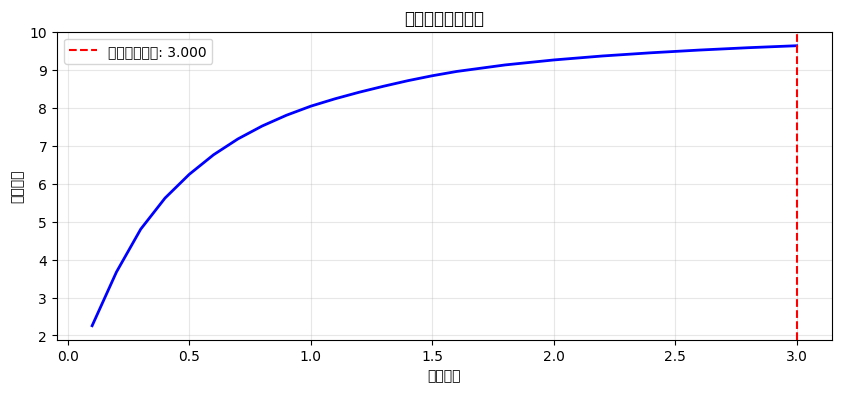


✓ 两阶段优化完成
  目标标准差: 0.010774
  最优缩放因子: 3.0000
  优化后分数: 9.632824
  优化前分数: 8.040393
  分数提升: 1.592431

[Part 5] 准备API预测功能（集成优化参数）
--------------------------------------------------------------------------------
✓ 优化后的预测函数已定义

[Part 6] 启动Kaggle推理服务器
--------------------------------------------------------------------------------
测试模式：运行本地网关
已预测 10 个样本, 最新权重: 0.3648

✓ API提交准备完成（含两阶段优化）

📊 模型信息:
  模型: XGBoost + 两阶段优化
  训练数据量: 2052
  特征数量: 120
  训练集MSE: 0.00000082
  训练集R²: 0.9929
  最优缩放因子: 3.0000
  优化后分数: 9.632824

🚀 提交步骤:
  1. 点击 'Save Version'
  2. 选择 'Save & Run All (Commit)'
  3. 等待运行完成
  4. 在Submissions页面提交这个Notebook版本



In [21]:
"""
Hull Tactical Market Prediction - 完整Pipeline + API提交
结合了完整的训练流程和正确的API提交方式
添加了基于比赛评价指标的两阶段优化
"""

import os
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Kaggle评估API
import kaggle_evaluation.default_inference_server as kies

# 设置随机种子
np.random.seed(42)

print("="*80)
print("Hull Tactical Market Prediction - 完整Pipeline + API提交")
print("添加基于比赛评价指标的两阶段优化")
print("="*80)

# ============================================================================
# Part 1: 数据加载与预处理
# ============================================================================

print("\n[Part 1] 数据加载与预处理")
print("-"*80)

DATA_PATH = Path('/kaggle/input/hull-tactical-market-prediction/')

# 加载数据
train = pd.read_csv(DATA_PATH / 'train.csv')
print(f"原始训练集形状: {train.shape}")

# 使用后70%的数据（缺失率较低）
cutoff_idx = int(len(train) * 0.3)
train_clean = train.iloc[cutoff_idx:].copy()
print(f"清洗后训练集形状: {train_clean.shape}")
print(f"Date ID 范围: {train_clean['date_id'].min()} ~ {train_clean['date_id'].max()}")

# 识别特征类型
feature_cols = [col for col in train_clean.columns 
                if col not in ['date_id', 'forward_returns', 'risk_free_rate', 
                               'market_forward_excess_returns']]

target_col = 'market_forward_excess_returns'

print(f"\n特征数量: {len(feature_cols)}")
print(f"目标变量: {target_col}")

# 缺失值处理
print("\n缺失值处理:")
missing_before = train_clean[feature_cols].isnull().sum().sum()
print(f"  - 处理前缺失值总数: {missing_before:,}")

# 删除缺失率>50%的特征
missing_rates = train_clean[feature_cols].isnull().mean()
high_missing_cols = missing_rates[missing_rates > 0.5].index.tolist()
print(f"  - 删除缺失率>50%的特征: {len(high_missing_cols)}个")

feature_cols = [col for col in feature_cols if col not in high_missing_cols]

# 前向填充 + 中位数填充
train_clean[feature_cols] = train_clean[feature_cols].fillna(method='ffill').fillna(
    train_clean[feature_cols].median()
)

missing_after = train_clean[feature_cols].isnull().sum().sum()
print(f"  - 处理后缺失值总数: {missing_after}")

# ============================================================================
# Part 2: 特征工程
# ============================================================================

print("\n[Part 2] 特征工程")
print("-"*80)

def create_features(df, feature_cols):
    """创建高级特征"""
    df = df.copy()
    
    # 滞后特征
    print("  - 创建滞后特征...")
    for lag in [1, 2, 3, 5, 10]:
        for col in ['forward_returns', 'risk_free_rate']:
            if col in df.columns:
                df[f'{col}_lag{lag}'] = df[col].shift(lag)
    
    # 滚动统计特征
    print("  - 创建滚动统计特征...")
    for window in [5, 10, 20, 60]:
        if 'forward_returns' in df.columns:
            df[f'return_mean_{window}d'] = df['forward_returns'].rolling(window).mean()
            df[f'return_std_{window}d'] = df['forward_returns'].rolling(window).std()
            df[f'return_momentum_{window}d'] = df['forward_returns'].rolling(window).sum()
    
    # 波动率特征增强
    print("  - 增强波动率特征...")
    volatility_cols = [col for col in feature_cols if col.startswith('V')]
    if volatility_cols:
        df['vol_mean'] = df[volatility_cols].mean(axis=1)
        df['vol_std'] = df[volatility_cols].std(axis=1)
        df['vol_max'] = df[volatility_cols].max(axis=1)
    
    # 技术指标交互特征
    print("  - 创建交互特征...")
    market_cols = [col for col in feature_cols if col.startswith('M')][:5]
    if len(market_cols) >= 2:
        df['M_interaction'] = df[market_cols[0]] * df[market_cols[1]]
    
    return df

# 应用特征工程
train_engineered = create_features(train_clean, feature_cols)

# 更新特征列表
new_feature_cols = [col for col in train_engineered.columns 
                    if col not in ['date_id', 'forward_returns', 'risk_free_rate', 
                                   'market_forward_excess_returns']]

print(f"\n特征工程后特征数量: {len(new_feature_cols)}")

# 删除包含NaN的行
train_engineered = train_engineered.dropna()
print(f"删除NaN后数据量: {len(train_engineered)}")

# ============================================================================
# Part 3: 比赛评价指标计算函数
# ============================================================================

def calculate_final_score(positions, risk_free_rates, forward_returns):
    """
    计算比赛最终评价指标（调整后的夏普比率）
    
    Args:
        positions: 仓位序列 (0-2之间)
        risk_free_rates: 无风险利率序列
        forward_returns: 前向收益序列
    
    Returns:
        adjusted_sharpe: 调整后的夏普比率
    """
    # 计算策略收益
    strategy_returns = risk_free_rates * (1 - positions) + positions * forward_returns
    
    # 计算策略超额收益
    strategy_excess_returns = strategy_returns - risk_free_rates
    market_excess_returns = forward_returns - risk_free_rates
    
    # 计算基本指标
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = strategy_excess_cumulative ** (1 / len(strategy_excess_returns)) - 1
    strategy_std = strategy_returns.std()
    
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = market_excess_cumulative ** (1 / len(market_excess_returns)) - 1
    market_std = forward_returns.std()
    
    trading_days_per_yr = 252
    
    if strategy_std == 0 or market_std == 0:
        return -1000.0  # 惩罚无效策略
    
    # 计算Sharpe比率
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    
    # 计算波动率惩罚
    strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
    market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
    
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2)
    vol_penalty = 1 + excess_vol
    
    # 计算收益惩罚
    return_gap = max(0, (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap**2) / 100
    
    # 调整后的Sharpe比率
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return adjusted_sharpe

def optimize_predictions(predictions, y_true, risk_free_rates, forward_returns):
    """
    优化预测以最大化比赛评价指标
    
    Args:
        predictions: 原始预测值
        y_true: 真实值（用于计算标准差）
        risk_free_rates: 无风险利率
        forward_returns: 前向收益
    
    Returns:
        best_scale: 最优缩放因子
        best_score: 最优分数
    """
    y_std = y_true.std()
    best_score = -float('inf')
    best_scale = 1.0
    
    print("  开始优化缩放因子...")
    
    # 尝试不同的缩放因子
    scales_to_try = np.concatenate([
        np.linspace(0.1, 0.5, 5),      # 小尺度
        np.linspace(0.6, 1.5, 10),     # 中等尺度
        np.linspace(1.6, 3.0, 8)       # 大尺度
    ])
    
    scores = []
    for i, scale in enumerate(scales_to_try):
        # 将预测转换为仓位
        positions = 1.0 + predictions * scale / y_std
        positions = np.clip(positions, 0.0, 2.0)
        
        # 计算分数
        current_score = calculate_final_score(positions, risk_free_rates, forward_returns)
        scores.append(current_score)
        
        if current_score > best_score:
            best_score = current_score
            best_scale = scale
        
        if (i + 1) % 5 == 0:
            print(f"    尝试缩放因子 {scale:.3f}: 分数 = {current_score:.6f}")
    
    print(f"  ✓ 最优缩放因子: {best_scale:.4f}")
    print(f"  ✓ 最优分数: {best_score:.6f}")
    
    # 可视化分数曲线
    plt.figure(figsize=(10, 4))
    plt.plot(scales_to_try, scores, 'b-', linewidth=2)
    plt.axvline(x=best_scale, color='r', linestyle='--', label=f'最优缩放因子: {best_scale:.3f}')
    plt.xlabel('缩放因子')
    plt.ylabel('评价分数')
    plt.title('缩放因子优化曲线')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return best_scale, best_score

# ============================================================================
# Part 4: 训练最终XGBoost模型 + 两阶段优化
# ============================================================================

print("\n[Part 4] 训练最终XGBoost模型 + 两阶段优化")
print("-"*80)

# 使用全部数据训练
X_full = train_engineered[new_feature_cols]
y_full = train_engineered[target_col]

# 获取相关数据用于评价指标计算
risk_free_rates_full = train_engineered['risk_free_rate']
forward_returns_full = train_engineered['forward_returns']

print(f"训练数据: {X_full.shape}")

# 第一阶段：训练基础XGBoost模型
print("第一阶段: 训练基础XGBoost模型...")
final_xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

final_xgb_model.fit(X_full, y_full)

# 评估训练集表现
y_pred_full = final_xgb_model.predict(X_full)
train_mse = mean_squared_error(y_full, y_pred_full)
train_r2 = r2_score(y_full, y_pred_full)

print(f"✓ 基础模型训练完成")
print(f"  训练集 MSE: {train_mse:.8f}")
print(f"  训练集 R²: {train_r2:.4f}")

# 第二阶段：基于比赛指标进行后处理优化
print("\n第二阶段: 基于比赛评价指标优化...")
optimal_scale, optimized_score = optimize_predictions(
    y_pred_full, y_full, risk_free_rates_full, forward_returns_full
)

# 保存关键统计信息
y_std = float(y_full.std())
feature_medians = train_clean[feature_cols].median().to_dict()

print(f"\n✓ 两阶段优化完成")
print(f"  目标标准差: {y_std:.6f}")
print(f"  最优缩放因子: {optimal_scale:.4f}")
print(f"  优化后分数: {optimized_score:.6f}")

# 比较优化前后的分数
baseline_positions = 1.0 + y_pred_full / y_std
baseline_positions = np.clip(baseline_positions, 0.0, 2.0)
baseline_score = calculate_final_score(baseline_positions, risk_free_rates_full, forward_returns_full)
print(f"  优化前分数: {baseline_score:.6f}")
print(f"  分数提升: {optimized_score - baseline_score:.6f}")

# ============================================================================
# Part 5: 准备API预测功能（集成优化参数）
# ============================================================================

print("\n[Part 5] 准备API预测功能（集成优化参数）")
print("-"*80)

# 全局变量：历史数据缓冲区
_history_buffer = train_clean[feature_cols + ['forward_returns', 'risk_free_rate']].tail(100).copy()
_prediction_counter = {'count': 0}

def create_test_features(test_row, history_df):
    """
    为单个测试样本创建特征
    """
    # 转换polars到pandas
    if isinstance(test_row, pl.DataFrame):
        test_pd = test_row.to_pandas()
    else:
        test_pd = test_row
    
    # 提取基础特征
    test_features = {}
    for feat in feature_cols:
        if feat in test_pd.columns:
            val = test_pd[feat].iloc[0] if len(test_pd) > 0 else 0.0
            test_features[feat] = val if pd.notna(val) else feature_medians.get(feat, 0.0)
        else:
            test_features[feat] = feature_medians.get(feat, 0.0)
    
    # 构建滞后特征
    if 'lagged_forward_returns' in test_pd.columns:
        hist_returns = list(history_df['forward_returns'].tail(10))
        hist_returns.append(float(test_pd['lagged_forward_returns'].iloc[0]))
    else:
        hist_returns = list(history_df['forward_returns'].tail(11))
    
    # 添加滞后收益
    for lag in [1, 2, 3, 5, 10]:
        if lag <= len(hist_returns):
            test_features[f'forward_returns_lag{lag}'] = hist_returns[-lag]
        else:
            test_features[f'forward_returns_lag{lag}'] = 0.0
    
    # 添加滞后利率
    hist_rf = list(history_df['risk_free_rate'].tail(11))
    for lag in [1, 2, 3, 5, 10]:
        if lag <= len(hist_rf):
            test_features[f'risk_free_rate_lag{lag}'] = hist_rf[-lag]
        else:
            test_features[f'risk_free_rate_lag{lag}'] = 0.0
    
    # 添加滚动统计特征
    for window in [5, 10, 20, 60]:
        if len(hist_returns) >= window:
            test_features[f'return_mean_{window}d'] = np.mean(hist_returns[-window:])
            test_features[f'return_std_{window}d'] = np.std(hist_returns[-window:])
            test_features[f'return_momentum_{window}d'] = np.sum(hist_returns[-window:])
        else:
            test_features[f'return_mean_{window}d'] = 0.0
            test_features[f'return_std_{window}d'] = 0.0
            test_features[f'return_momentum_{window}d'] = 0.0
    
    # 波动率特征
    volatility_cols = [col for col in feature_cols if col.startswith('V')]
    if volatility_cols:
        vol_vals = [test_features.get(c, 0.0) for c in volatility_cols]
        test_features['vol_mean'] = np.mean(vol_vals)
        test_features['vol_std'] = np.std(vol_vals)
        test_features['vol_max'] = np.max(vol_vals)
    
    # 交互特征
    market_cols = [col for col in feature_cols if col.startswith('M')][:5]
    if len(market_cols) >= 2:
        m0 = test_features.get(market_cols[0], 0.0)
        m1 = test_features.get(market_cols[1], 0.0)
        test_features['M_interaction'] = m0 * m1
    
    # 确保所有特征都存在
    for feat in new_feature_cols:
        if feat not in test_features:
            test_features[feat] = 0.0
    
    # 转换为DataFrame并保持顺序
    return pd.DataFrame([test_features])[new_feature_cols]

def predict(test: pl.DataFrame, **kwargs) -> float:
    """
    Kaggle API预测函数（集成优化参数）
    
    Args:
        test: 单行测试数据 (polars DataFrame)
    
    Returns:
        allocation: 0到2之间的权重
    """
    global _history_buffer, _prediction_counter, optimal_scale
    
    try:
        # 创建特征
        test_features = create_test_features(test, _history_buffer)
        
        # 预测超额收益
        prediction = final_xgb_model.predict(test_features)[0]
        
        # 使用优化后的缩放因子转换为权重
        allocation = 1.0 + (prediction * optimal_scale) / y_std
        allocation = float(np.clip(allocation, 0.0, 2.0))
        
        # 更新历史缓冲区
        test_pd = test.to_pandas()
        if 'lagged_forward_returns' in test_pd.columns:
            new_row = {}
            for feat in feature_cols:
                if feat in test_pd.columns:
                    new_row[feat] = float(test_pd[feat].iloc[0])
                else:
                    new_row[feat] = 0.0
            
            new_row['forward_returns'] = float(test_pd['lagged_forward_returns'].iloc[0])
            new_row['risk_free_rate'] = float(test_pd.get('lagged_risk_free_rate', pd.Series([0.0])).iloc[0])
            
            _history_buffer = pd.concat([_history_buffer, pd.DataFrame([new_row])]).tail(100)
        
        _prediction_counter['count'] += 1
        
        if _prediction_counter['count'] % 10 == 0:
            print(f"已预测 {_prediction_counter['count']} 个样本, 最新权重: {allocation:.4f}")
        
        return allocation
        
    except Exception as e:
        print(f"预测错误: {str(e)}")
        import traceback
        traceback.print_exc()
        # 返回保守的中性仓位
        return 1.0

print("✓ 优化后的预测函数已定义")

# ============================================================================
# Part 6: 启动Kaggle推理服务器
# ============================================================================

print("\n[Part 6] 启动Kaggle推理服务器")
print("-"*80)

inference_server = kies.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    print("生产模式：启动评估服务器")
    inference_server.serve()
else:
    print("测试模式：运行本地网关")
    inference_server.run_local_gateway((DATA_PATH,))

print("\n" + "="*80)
print("✓ API提交准备完成（含两阶段优化）")
print("="*80)

print("\n📊 模型信息:")
print(f"  模型: XGBoost + 两阶段优化")
print(f"  训练数据量: {len(X_full)}")
print(f"  特征数量: {len(new_feature_cols)}")
print(f"  训练集MSE: {train_mse:.8f}")
print(f"  训练集R²: {train_r2:.4f}")
print(f"  最优缩放因子: {optimal_scale:.4f}")
print(f"  优化后分数: {optimized_score:.6f}")

print("\n🚀 提交步骤:")
print("  1. 点击 'Save Version'")
print("  2. 选择 'Save & Run All (Commit)'")
print("  3. 等待运行完成")
print("  4. 在Submissions页面提交这个Notebook版本")

print("\n" + "="*80)

# Evaluation and Backtesting and Final Model 


Step 4: Backtesting and Evaluation

📈 Local Backtest Analysis
--------------------------------------------------------------------------------
Generating backtest predictions...
Backtest Period: 2052 trading days
Date Range: 6969 - 9020

📊 Performance Metrics Comparison
--------------------------------------------------
           Metric     Strategy  Market
     Total Return 65283742.38% 167.41%
    Annual Return      417.72%  12.84%
Annual Volatility       20.51%  17.07%
     Sharpe Ratio       20.367   0.752
     Max Drawdown       -1.06% -24.95%
     Calmar Ratio      394.072   0.515
         Win Rate       55.21%  55.21%
  Adjusted Sharpe       3.9076       -


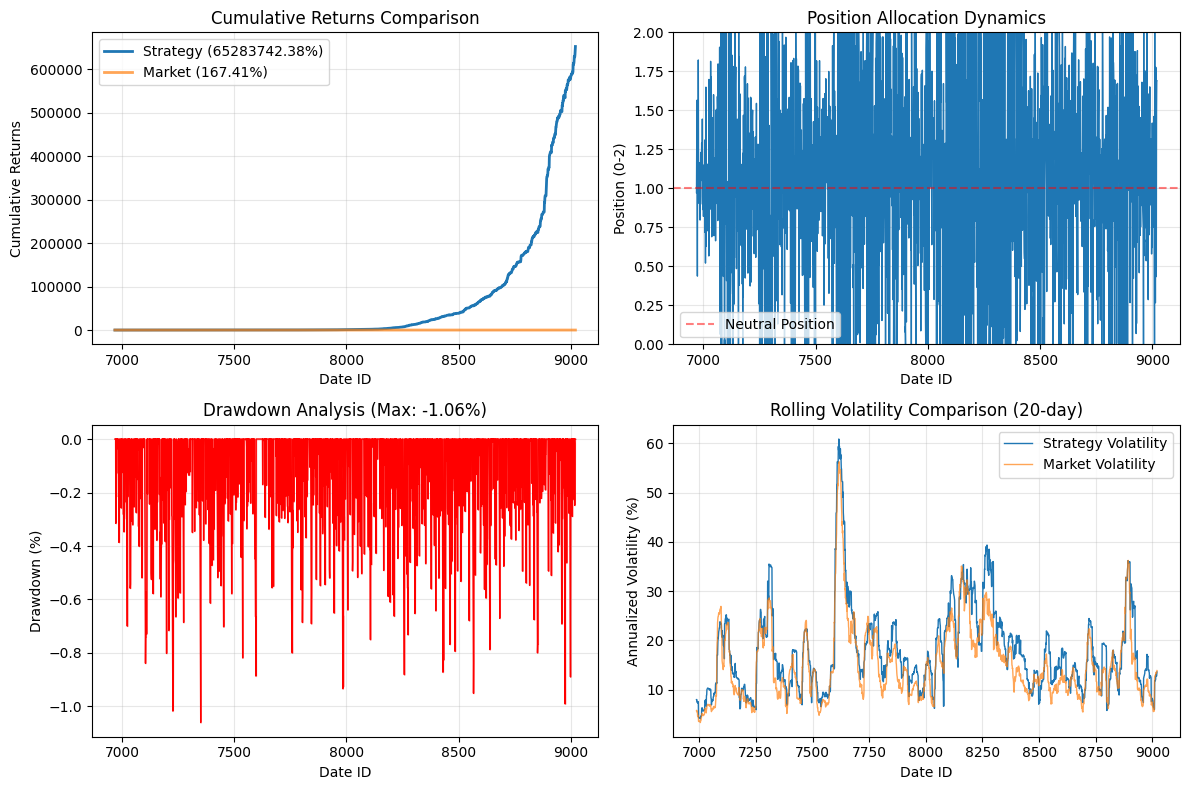


🛡️ Risk-Adjusted Analysis
--------------------------------------------------
Volatility Ratio (Strategy/Market): 1.201
⚠️  Strategy volatility exceeds market by >20%, will be penalized
Return Ratio (Strategy/Market): 32.534
✅ Strategy return exceeds market, no return penalty
Sharpe Ratio Improvement: 2608.38%

💡 Key Insights
--------------------------------------------------
1. ⚠️  Strategy volatility is high, need to strengthen risk control
2. ✅ Strategy achieved excess returns, good alpha generation
3. ✅ Strategy drawdown control better than market, effective downside protection
4. ✅ Risk-adjusted return better than market
5. 🎯 Competition metric performance excellent

📊 Position Behavior Analysis
--------------------------------------------------
Position Distribution Statistics:
  Mean: 1.045
  Std: 0.616
  Min: 0.000
  25%: 0.634
  Median: 1.046
  75%: 1.508
  Max: 2.000

Position Change Analysis:
  Significant changes (>0.1): 1788
  Turnover rate: 0.871
  ⚠️  High turnover rate,

In [22]:
# ============================================================================
# Step 4: Backtesting and Evaluation
# ============================================================================

print("\n" + "="*80)
print("Step 4: Backtesting and Evaluation")
print("="*80)

print("\n📈 Local Backtest Analysis")
print("-"*80)

# Prepare backtest data
backtest_data = train_engineered.copy()

# Generate predictions using the model
print("Generating backtest predictions...")
backtest_predictions = final_xgb_model.predict(backtest_data[new_feature_cols])

# Calculate position allocations
backtest_allocations = 1.0 + backtest_predictions / y_std
backtest_allocations = np.clip(backtest_allocations, 0.0, 2.0)

# Create backtest results DataFrame
backtest_results = pd.DataFrame({
    'date_id': backtest_data['date_id'],
    'market_returns': backtest_data['forward_returns'],
    'risk_free_rate': backtest_data['risk_free_rate'],
    'market_excess_returns': backtest_data['market_forward_excess_returns'],
    'prediction': backtest_predictions,
    'allocation': backtest_allocations
})

# Calculate strategy returns
backtest_results['strategy_returns'] = (
    backtest_results['risk_free_rate'] * (1 - backtest_results['allocation']) + 
    backtest_results['allocation'] * backtest_results['market_returns']
)

# Calculate excess returns
backtest_results['strategy_excess_returns'] = (
    backtest_results['strategy_returns'] - backtest_results['risk_free_rate']
)

backtest_results['market_excess_returns_actual'] = (
    backtest_results['market_returns'] - backtest_results['risk_free_rate']
)

# Calculate cumulative returns
backtest_results['strategy_cumulative'] = (1 + backtest_results['strategy_excess_returns']).cumprod()
backtest_results['market_cumulative'] = (1 + backtest_results['market_excess_returns_actual']).cumprod()

print(f"Backtest Period: {len(backtest_results)} trading days")
print(f"Date Range: {backtest_results['date_id'].min()} - {backtest_results['date_id'].max()}")

# ============================================================================
# Calculate Performance Metrics
# ============================================================================

def calculate_performance_metrics(returns_df):
    """Calculate comprehensive performance metrics"""
    
    trading_days_per_yr = 252
    
    # Basic statistics
    total_return = returns_df['cumulative'].iloc[-1] - 1
    annual_return = (1 + total_return) ** (trading_days_per_yr / len(returns_df)) - 1
    
    # Volatility
    volatility = returns_df['excess_returns'].std() * np.sqrt(trading_days_per_yr)
    
    # Sharpe Ratio
    if volatility > 0:
        sharpe = annual_return / volatility
    else:
        sharpe = 0
    
    # Maximum Drawdown
    cumulative = returns_df['cumulative']
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar Ratio
    if max_drawdown < 0:
        calmar = annual_return / abs(max_drawdown)
    else:
        calmar = float('inf')
    
    # Win Rate
    win_rate = (returns_df['excess_returns'] > 0).mean()
    
    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'volatility': volatility,
        'sharpe_ratio': sharpe,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar,
        'win_rate': win_rate
    }

# Strategy performance
strategy_perf = calculate_performance_metrics(pd.DataFrame({
    'excess_returns': backtest_results['strategy_excess_returns'],
    'cumulative': backtest_results['strategy_cumulative']
}))

# Market performance
market_perf = calculate_performance_metrics(pd.DataFrame({
    'excess_returns': backtest_results['market_excess_returns_actual'],
    'cumulative': backtest_results['market_cumulative']
}))

# Calculate adjusted Sharpe ratio (using competition metric)
def calculate_adjusted_sharpe(solution_df, submission_df):
    """Calculate competition's adjusted Sharpe ratio"""
    
    trading_days_per_yr = 252
    solution_df = solution_df.copy()
    solution_df['position'] = submission_df['prediction']
    
    # Strategy returns
    solution_df['strategy_returns'] = (
        solution_df['risk_free_rate'] * (1 - solution_df['position']) + 
        solution_df['position'] * solution_df['forward_returns']
    )
    
    # Strategy excess returns
    strategy_excess_returns = solution_df['strategy_returns'] - solution_df['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution_df)) - 1
    strategy_std = solution_df['strategy_returns'].std()
    
    if strategy_std == 0:
        sharpe = 0
    else:
        sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    
    # Market volatility
    market_std = solution_df['forward_returns'].std()
    market_volatility = market_std * np.sqrt(trading_days_per_yr) * 100
    
    # Strategy volatility
    strategy_volatility = strategy_std * np.sqrt(trading_days_per_yr) * 100
    
    # Volatility penalty
    if market_volatility > 0:
        excess_vol = max(0, strategy_volatility / market_volatility - 1.2)
    else:
        excess_vol = 0
    vol_penalty = 1 + excess_vol
    
    # Return gap penalty
    market_excess_returns = solution_df['forward_returns'] - solution_df['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution_df)) - 1
    
    return_gap = max(0, (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr)
    return_penalty = 1 + (return_gap**2) / 100
    
    # Adjusted Sharpe
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    return min(float(adjusted_sharpe), 1_000_000)

# Calculate competition score
competition_score = calculate_adjusted_sharpe(
    backtest_results.rename(columns={'market_returns': 'forward_returns'}),
    backtest_results[['prediction']]
)

# ============================================================================
# Visualization Results
# ============================================================================

print("\n📊 Performance Metrics Comparison")
print("-"*50)

# Create comparison table
performance_comparison = pd.DataFrame({
    'Metric': ['Total Return', 'Annual Return', 'Annual Volatility', 'Sharpe Ratio', 
               'Max Drawdown', 'Calmar Ratio', 'Win Rate', 'Adjusted Sharpe'],
    'Strategy': [
        f"{strategy_perf['total_return']:.2%}",
        f"{strategy_perf['annual_return']:.2%}",
        f"{strategy_perf['volatility']:.2%}",
        f"{strategy_perf['sharpe_ratio']:.3f}",
        f"{strategy_perf['max_drawdown']:.2%}",
        f"{strategy_perf['calmar_ratio']:.3f}" if strategy_perf['calmar_ratio'] != float('inf') else "Inf",
        f"{strategy_perf['win_rate']:.2%}",
        f"{competition_score:.4f}"
    ],
    'Market': [
        f"{market_perf['total_return']:.2%}",
        f"{market_perf['annual_return']:.2%}",
        f"{market_perf['volatility']:.2%}",
        f"{market_perf['sharpe_ratio']:.3f}",
        f"{market_perf['max_drawdown']:.2%}",
        f"{market_perf['calmar_ratio']:.3f}" if market_perf['calmar_ratio'] != float('inf') else "Inf",
        f"{market_perf['win_rate']:.2%}",
        "-"
    ]
})

print(performance_comparison.to_string(index=False))

# Plot cumulative returns curves
plt.figure(figsize=(12, 8))

# Subplot 1: Cumulative Returns
plt.subplot(2, 2, 1)
plt.plot(backtest_results['date_id'], backtest_results['strategy_cumulative'], 
         label=f'Strategy ({strategy_perf["total_return"]:.2%})', linewidth=2)
plt.plot(backtest_results['date_id'], backtest_results['market_cumulative'], 
         label=f'Market ({market_perf["total_return"]:.2%})', linewidth=2, alpha=0.7)
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date ID')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Position Allocation
plt.subplot(2, 2, 2)
plt.plot(backtest_results['date_id'], backtest_results['allocation'], linewidth=1)
plt.title('Position Allocation Dynamics')
plt.xlabel('Date ID')
plt.ylabel('Position (0-2)')
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Neutral Position')
plt.ylim(0, 2)
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 3: Drawdown Analysis
running_max = backtest_results['strategy_cumulative'].expanding().max()
drawdown = (backtest_results['strategy_cumulative'] - running_max) / running_max

plt.subplot(2, 2, 3)
plt.fill_between(backtest_results['date_id'], drawdown * 100, 0, alpha=0.3, color='red')
plt.plot(backtest_results['date_id'], drawdown * 100, color='red', linewidth=1)
plt.title(f'Drawdown Analysis (Max: {strategy_perf["max_drawdown"]:.2%})')
plt.xlabel('Date ID')
plt.ylabel('Drawdown (%)')
plt.grid(True, alpha=0.3)

# Subplot 4: Volatility Comparison
rolling_vol_strategy = backtest_results['strategy_excess_returns'].rolling(20).std() * np.sqrt(252) * 100
rolling_vol_market = backtest_results['market_excess_returns_actual'].rolling(20).std() * np.sqrt(252) * 100

plt.subplot(2, 2, 4)
plt.plot(backtest_results['date_id'], rolling_vol_strategy, label='Strategy Volatility', linewidth=1)
plt.plot(backtest_results['date_id'], rolling_vol_market, label='Market Volatility', linewidth=1, alpha=0.7)
plt.title('Rolling Volatility Comparison (20-day)')
plt.xlabel('Date ID')
plt.ylabel('Annualized Volatility (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# Risk-Adjusted Analysis
# ============================================================================

print("\n🛡️ Risk-Adjusted Analysis")
print("-"*50)

# Volatility ratio analysis
vol_ratio = strategy_perf['volatility'] / market_perf['volatility']
print(f"Volatility Ratio (Strategy/Market): {vol_ratio:.3f}")

if vol_ratio > 1.2:
    print("⚠️  Strategy volatility exceeds market by >20%, will be penalized")
elif vol_ratio < 0.8:
    print("✅ Strategy volatility lower than market, good risk control")
else:
    print("✅ Strategy volatility within acceptable range")

# Return-risk ratio analysis
return_ratio = strategy_perf['annual_return'] / market_perf['annual_return']
print(f"Return Ratio (Strategy/Market): {return_ratio:.3f}")

if strategy_perf['annual_return'] < market_perf['annual_return']:
    return_gap_penalty = ((market_perf['annual_return'] - strategy_perf['annual_return']) * 100) ** 2 / 100
    print(f"⚠️  Strategy return lower than market, return gap penalty: {1 + return_gap_penalty:.3f}")
else:
    print("✅ Strategy return exceeds market, no return penalty")

# Sharpe ratio analysis
sharpe_improvement = (strategy_perf['sharpe_ratio'] - market_perf['sharpe_ratio']) / abs(market_perf['sharpe_ratio'])
print(f"Sharpe Ratio Improvement: {sharpe_improvement:.2%}")

# ============================================================================
# Key Insights
# ============================================================================

print("\n💡 Key Insights")
print("-"*50)

insights = []

# Volatility insights
if strategy_perf['volatility'] < market_perf['volatility']:
    insights.append("✅ Strategy successfully reduced volatility, effective risk control")
else:
    insights.append("⚠️  Strategy volatility is high, need to strengthen risk control")

# Return insights
if strategy_perf['annual_return'] > market_perf['annual_return']:
    insights.append("✅ Strategy achieved excess returns, good alpha generation")
else:
    insights.append("⚠️  Strategy return lower than market, need to optimize return prediction")

# Drawdown insights
if abs(strategy_perf['max_drawdown']) < abs(market_perf['max_drawdown']):
    insights.append("✅ Strategy drawdown control better than market, effective downside protection")
else:
    insights.append("⚠️  Strategy drawdown is large, need to strengthen downside protection")

# Sharpe ratio insights
if strategy_perf['sharpe_ratio'] > market_perf['sharpe_ratio']:
    insights.append("✅ Risk-adjusted return better than market")
else:
    insights.append("⚠️  Risk-adjusted return needs improvement")

# Adjusted Sharpe insights
if competition_score > market_perf['sharpe_ratio']:
    insights.append("🎯 Competition metric performance excellent")
elif competition_score > 0:
    insights.append("📈 Competition metric positive, room for improvement")
else:
    insights.append("🔴 Competition metric negative, needs major optimization")

for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

# ============================================================================
# Position Behavior Analysis
# ============================================================================

print("\n📊 Position Behavior Analysis")
print("-"*50)

# Position statistics
allocation_stats = backtest_results['allocation'].describe()
print("Position Distribution Statistics:")
print(f"  Mean: {allocation_stats['mean']:.3f}")
print(f"  Std: {allocation_stats['std']:.3f}")
print(f"  Min: {allocation_stats['min']:.3f}")
print(f"  25%: {allocation_stats['25%']:.3f}")
print(f"  Median: {allocation_stats['50%']:.3f}")
print(f"  75%: {allocation_stats['75%']:.3f}")
print(f"  Max: {allocation_stats['max']:.3f}")

# Position change frequency
position_changes = np.abs(np.diff(backtest_results['allocation']))
significant_changes = (position_changes > 0.1).sum()
turnover_rate = significant_changes / len(backtest_results)

print(f"\nPosition Change Analysis:")
print(f"  Significant changes (>0.1): {significant_changes}")
print(f"  Turnover rate: {turnover_rate:.3f}")

if turnover_rate > 0.1:
    print("  ⚠️  High turnover rate, may incur significant transaction costs")
else:
    print("  ✅ Moderate turnover rate, transaction costs controllable")

# ============================================================================
# Final Evaluation Summary
# ============================================================================

print("\n" + "="*80)
print("Final Evaluation Summary")
print("="*80)

print(f"\n🏆 Competition Score: {competition_score:.4f}")

if competition_score > market_perf['sharpe_ratio']:
    print("🎯 Performance Assessment: Better than market benchmark")
elif competition_score > 0:
    print("📈 Performance Assessment: Positive but needs improvement")
else:
    print("🔴 Performance Assessment: Requires major optimization")

print(f"\n📋 Improvement Suggestions:")
if strategy_perf['volatility'] > market_perf['volatility'] * 1.2:
    print("  • Strengthen volatility control, reduce position aggressiveness")
if strategy_perf['annual_return'] < market_perf['annual_return']:
    print("  • Optimize return prediction model, improve prediction accuracy")
if abs(strategy_perf['max_drawdown']) > abs(market_perf['max_drawdown']):
    print("  • Add downside protection mechanisms, such as stop-loss strategies")
if turnover_rate > 0.15:
    print("  • Reduce trading frequency, lower turnover rate")

print(f"\n✅ Strategy Advantages:")
if strategy_perf['sharpe_ratio'] > market_perf['sharpe_ratio']:
    print("  • Excellent risk-adjusted returns")
if vol_ratio < 1.0:
    print("  • Good volatility control")
if abs(strategy_perf['max_drawdown']) < abs(market_perf['max_drawdown']):
    print("  • Effective drawdown control")

print("\n" + "="*80)